# Training
---
### Import the necessary packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from collab_and_comp.agent import Agent

### Instantiate the environment

In [2]:
env = UnityEnvironment(file_name="Tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Instantiate the agent

In [3]:
# get the default brain (the interface for the agent)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# create a new agent
agent = Agent(state_size=24, action_size=2, random_seed=1)

### Train the agent using the MADDPG algorithm

In [4]:
def maddpg(n_episodes=10000, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    beta = 1.0  # factor the random noise gets multiplied with
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # get the current states
        e_scores = np.zeros(2)  # the scores of an episode for both tennis agents
        agent.reset()
        for t in range(max_t):
            if i_episode < 100:
                actions = np.random.randn(2, 2)  # use random actions for the first 100 episodes
            else:
                actions = agent.act(states, noise_factor=beta)  # let the agent select actions
            actions_other_player = np.flip(actions, 0)          # The actions of the other player
            env_info = env.step(actions)[brain_name]            # execute the selected actions and save the new information about the environment
            rewards = env_info.rewards                          # get the rewards
            next_states = env_info.vector_observations          # get the resulting states
            next_states_other_player = np.flip(next_states, 0)  # get the resulting states for the other player
            dones = env_info.local_done                         # check whether episodes have finished
            agent.step(states, actions, actions_other_player, rewards, next_states, next_states_other_player, dones)  # pass the information to the agent
            states = next_states
            e_scores += rewards
            if np.any(dones):
                break
        max_score = np.max(e_scores)  # the max score of the agents
        scores_deque.append(max_score)
        scores.append(max_score)
        beta = max(0.999 * beta, 0.01)  # reduce the noise a bit while training
        print('\rEpisode {:d}\tmax score: {:.2f}\taverage maximum score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        if i_episode % 250 == 0:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_{:d}_{:.2f}.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = maddpg()
env.close()  # close the environment as it is no longer needed

Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.09
Episode 500	Average Score: 0.15
Episode 567	max score: 2.70	average maximum score over the last 10 episodes: 2.64
Environment solved in 467 episodes!	Average Score: 0.51


### Plot the scores

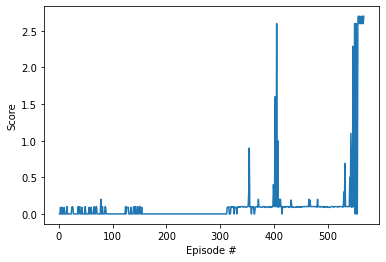

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()